UTILITIES:

sudo apt-get purge nvidia-* 


semantic dispersion through blocks. Perplexity
https://www.perplexity.ai/search/i-m-using-the-pair-cosine-simi-MX2xmvL8R2u5Z2CTC3MRqw



In [1]:
from collections import OrderedDict
import torch
import torch.nn.functional as F

import nnsight
from nnsight import NNsight

from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

from nnsight import LanguageModel

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/ailab/Code/MechInt/feature-circuits/experiments')

#from embedding_analysis import BlocksEmbeddingAnalysis
from embedding_analysis import EmbeddingAnalysis

# Model inizialization

+ **wte** = word token embedding  [num_tokens, emb_dim]
    + 50257 vocab dim 
    + 768 embedding dim

+ **wpe** = word position embedding [num_tokens, emb_dim]
    + 1024 max sequence lenght
    + 768 embedding dim 

<p align="left">
    <strong>residual = wte + wpe</strong>
</p>


LLM Visualization https://bbycroft.net/llm

In [2]:
#Model Initialization
llm = LanguageModel("openai-community/gpt2", device_map="cuda")#, device_map="auto")

print(type(llm))

<class 'nnsight.modeling.language.LanguageModel'>


In [3]:
num_blocks = len(llm.transformer.h)
print(f"Number of blocks in the model: {num_blocks}")


Number of blocks in the model: 12


# Inputs

In [4]:
# Input string
text = "The Eiffel Tower is in the city of"
# High variance text
high_variance_text = """The quantum mechanics lecture covered topics from wave-particle duality 
to Schrödinger's cat, while the culinary class next door was busy preparing a variety of exotic dishes."""

# Low variance text
low_variance_text = """The cat sat on the mat, purring softly as it basked in the warm sunlight streaming 
through the window."""



print(f"Number of GPT tokens in text: {len(llm.tokenizer.encode(text))}")

print(f"Number of GPT tokens in high variance text: {len(llm.tokenizer.encode(high_variance_text))}")
print(f"Number of GPT tokens in low variance text: {len(llm.tokenizer.encode(low_variance_text))}")

Number of GPT tokens in text: 10
Number of GPT tokens in high variance text: 38
Number of GPT tokens in low variance text: 25


In [5]:
llm.tokenizer.encode(text)

[464, 412, 733, 417, 8765, 318, 287, 262, 1748, 286]

# Model - nnsight

In [6]:
with llm.trace(text):

    # Access the last layer using h[-1] as it's a ModuleList
    # Access the first index of .output as that's where the hidden states are.

    token_embed = llm.transformer.wte.output.save()    
    pos_embed = llm.transformer.wpe.output.save()
    input_embed = llm.transformer.drop.input.save()
    #llm.transformer.h[-1].mlp.output[0][:] = 0
    ln_0 = llm.transformer.h[0].ln_1.output.save()
    #attn_0 = llm.transformer.h[0].attn.output.save()

    # Access the residual stream after the MLP of the 3rd GPT block
    residual_after_mlp_3 = llm.transformer.h[2].mlp.output.save()

    # Logits come out of model.lm_head and we apply argmax to get the predicted token ids.
    token_ids = llm.lm_head.output.argmax(dim=-1).save()

print("\nToken IDs:", token_ids)
print("type:", type(token_embed))

# Apply the tokenizer to decode the ids into words after the tracing context.
print("Prediction:", llm.tokenizer.decode(token_ids[0][-1]))
print("Residual after MLP of 3rd GPT block:", residual_after_mlp_3.shape)


Token IDs: tensor([[ 198,   12,  417, 8765,  318,  257,  262, 3504, 7372, 6342]],
       device='cuda:0')
type: <class 'torch.Tensor'>
Prediction:  Paris
Residual after MLP of 3rd GPT block: torch.Size([1, 10, 768])


In [7]:
# André
# llm.transformer(llm.tokenizer.encode(text))

In [8]:
with llm.trace(text):

    # Access the last layer using h[-1] as it's a ModuleList
    # Access the first index of .output as that's where the hidden states are.

    token_embed = llm.transformer.wte.output.save()    
    pos_embed = llm.transformer.wpe.output.save()
    input_embed = llm.transformer.drop.input.save()
    #llm.transformer.h[-1].mlp.output[0][:] = 0
    ln_0 = llm.transformer.h[0].ln_1.output.save()
    #attn_0 = llm.transformer.h[0].attn.output.save()

    # Logits come out of model.lm_head and we apply argmax to get the predicted token ids.
    token_ids = llm.lm_head.output.argmax(dim=-1).save()

print("\nToken IDs:", token_ids)
print("type:", type(token_embed))

# Apply the tokenizer to decode the ids into words after the tracing context.
print("Prediction:", llm.tokenizer.decode(token_ids[0][-1]))


Token IDs: tensor([[ 198,   12,  417, 8765,  318,  257,  262, 3504, 7372, 6342]],
       device='cuda:0')
type: <class 'torch.Tensor'>
Prediction:  Paris


In [9]:
#Prediction for each input token
for i, id in enumerate(token_ids[0]):
    print(llm.tokenizer.decode(llm.tokenizer.encode(text)[i]), "--->",  llm.tokenizer.decode(id))

The ---> 

 E ---> -
iff ---> el
el --->  Tower
 Tower --->  is
 is --->  a
 in --->  the
 the --->  middle
 city --->  centre
 of --->  Paris


In [10]:
ln_0.shape

torch.Size([1, 10, 768])

# Check embedding 

In [11]:
token_embed.shape, pos_embed.shape

(torch.Size([1, 10, 768]), torch.Size([1, 10, 768]))

In [12]:
residual_input = token_embed + pos_embed

In [13]:
input_embed.shape, token_embed.shape, residual_input.shape

(torch.Size([1, 10, 768]), torch.Size([1, 10, 768]), torch.Size([1, 10, 768]))

In [14]:
type(input_embed)

torch.Tensor

In [15]:
torch.equal(residual_input, input_embed)

True

In [16]:
input_embed.shape, input_embed[0].shape

(torch.Size([1, 10, 768]), torch.Size([10, 768]))

# Results
text --> 0.046019245  



#### Cosine Similarity
Definition: Cosine similarity measures the cosine of the angle between two vectors.  
It is calculated as:
$$ \text{cosine\_similarity}(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\| \|\mathbf{b}\|} $$
if $\mathbf{a}$ and $\mathbf{b}$ are normalized vetors $\implies$ $\|\mathbf{a}\| = 1$ and $\|\mathbf{b}\| = 1$: 
$$ \text{cosine\_similarity}(\mathbf{a}, \mathbf{b}) = {\mathbf{a} \cdot \mathbf{b}} $$


+ **Normalization**: Normalizing vectors to unit length ensures that cosine similarity measures directional similarity, independent of vector magnitudes.

+ **Scale Invariance**: Cosine similarity is invariant to the magnitude of the vectors. It focuses on the orientation (**direction**) of the vectors, making it useful when the magnitude is not important.

**Cosine Similarity** summary: 
+ Measures the angle between vectors, 
+ invariant to magnitude, 
+ useful for directional data.



#### Euclidean Distance
Definition: Euclidean distance measures the straight-line distance between two points in Euclidean space.  
It is calculated as:

$$ \text{euclidean\_distance}(\mathbf{a}, \mathbf{b}) = \sqrt{\sum_{i=1}^{n} (a_i - b_i)^2} $$

where $a_i$ and $b_i$ are the components of vectors $\mathbf{a}$ and $\mathbf{b}$.

Pros:

+ **Intuitive**: Euclidean distance is a straightforward and intuitive measure of distance between points.
+ **Sensitive to Magnitude**: It captures both the direction and magnitude of the vectors, making it useful when the absolute differences are important.
Cons:

+ **Scale Sensitivity**: Euclidean distance is sensitive to the scale of the vectors. Differences in magnitude can dominate the distance measure, which may not be desirable in some cases.
Not Invariant to Magnitude: Unlike cosine similarity, it does not normalize the vectors, so vectors with different magnitudes can have large distances even if they are in the same direction.

**Euclidean Distance** summary: 
+ Measures the straight-line distance, 
+ sensitive to magnitude, 
+ intuitive for geometric distances.


# Class EmbeddingAnalysis 

In [17]:
analysis = EmbeddingAnalysis(llm, text)
lst_embeddings_through_blocks_text = analysis.trace_embeddings_through_blocks()
len(lst_embeddings_through_blocks_text), lst_embeddings_through_blocks_text[0].shape, lst_embeddings_through_blocks_text[1].shape, lst_embeddings_through_blocks_text[7].shape

Model not supported
Model not supported


(13,
 torch.Size([1, 10, 768]),
 torch.Size([1, 10, 768]),
 torch.Size([1, 10, 768]))

In [18]:
analysis = EmbeddingAnalysis(llm, text)
mean_cosine_similarity = analysis.get_mean_cosine_similarity()
mean_cosine_similarity


Model not supported


0.6848686337471008

# text = "The Eiffel Tower is in the city of" 

In [19]:
text

'The Eiffel Tower is in the city of'

Model not supported
Mean Cosine Similarity: 0.6848686337471008


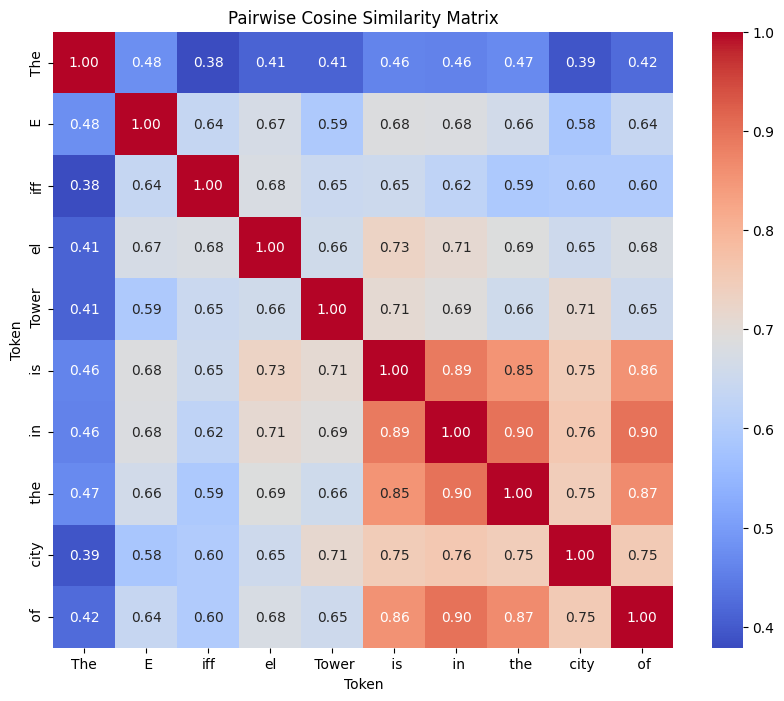

Mean Euclidean Distance: 4.586528301239014


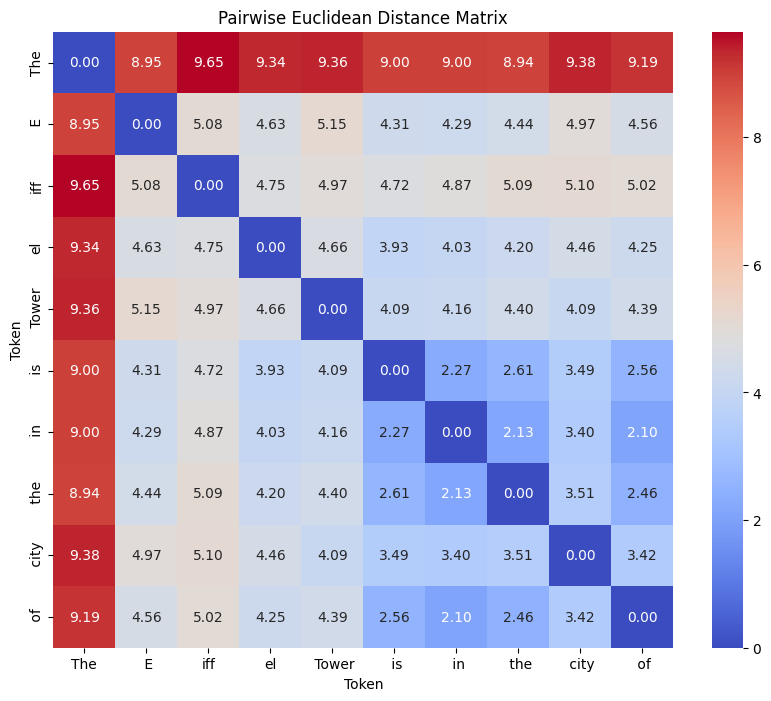

In [20]:
# Usage
analysis = EmbeddingAnalysis(llm, text)
analysis.analyze()

In [21]:
#check cosine similarity
cosine_sim_0_1 = F.cosine_similarity(input_embed[0][0], input_embed[0][1], dim=0)
cosine_sim_0_2 = F.cosine_similarity(input_embed[0][0], input_embed[0][2], dim=0)
cosine_sim_0_1, cosine_sim_0_2

(tensor(0.4774, device='cuda:0', grad_fn=<SumBackward1>),
 tensor(0.3789, device='cuda:0', grad_fn=<SumBackward1>))

In [22]:
# check
euclidean_distance_0_1 = torch.norm(input_embed[0][0] - input_embed[0][1], p=2)
euclidean_distance_0_2 = torch.norm(input_embed[0][0] - input_embed[0][2], p=2)

euclidean_distance_0_1, euclidean_distance_0_2

(tensor(8.9531, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>),
 tensor(9.6535, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>))

# high_variance_text

In [23]:
print(high_variance_text)

The quantum mechanics lecture covered topics from wave-particle duality 
to Schrödinger's cat, while the culinary class next door was busy preparing a variety of exotic dishes.


Model not supported
Mean Cosine Similarity: 0.5807138085365295


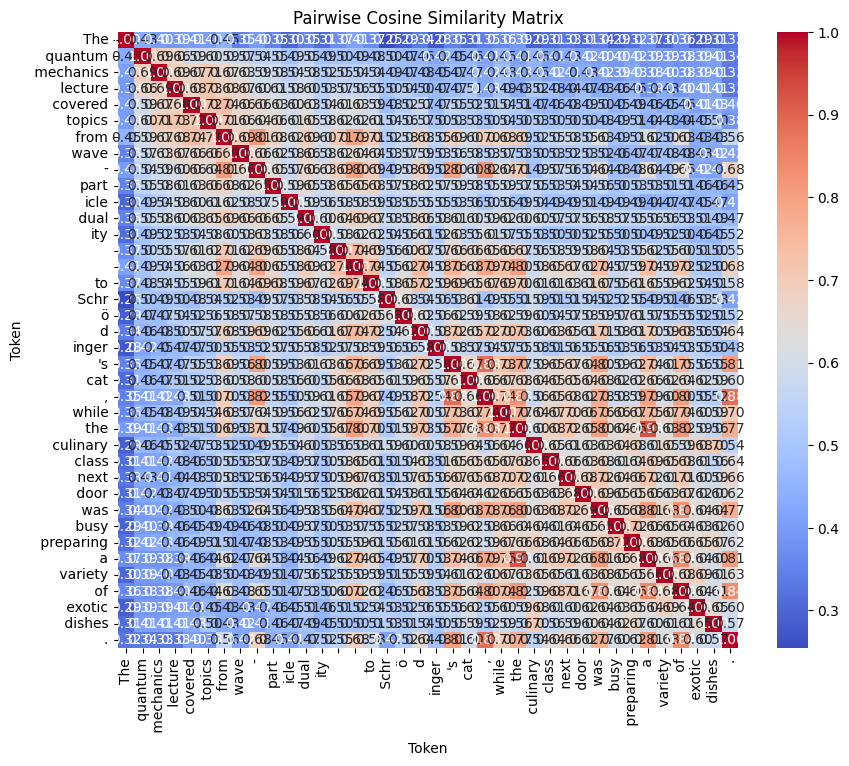

Mean Euclidean Distance: 4.793766975402832


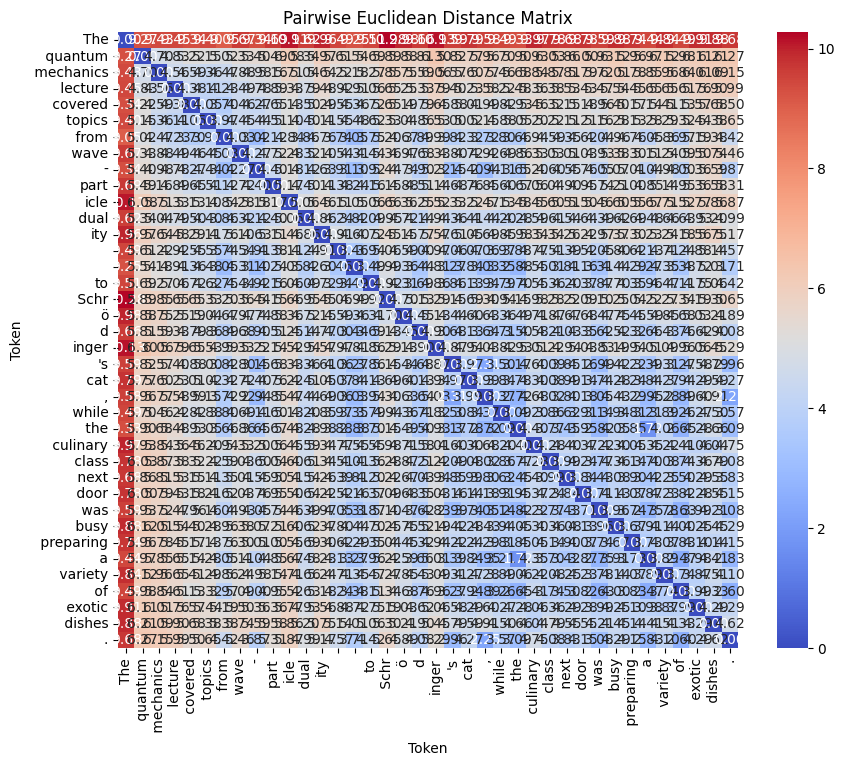

In [24]:
analysis_high = EmbeddingAnalysis(llm, high_variance_text)
analysis_high.analyze()

# low_variance_text

In [25]:
print(low_variance_text)

The cat sat on the mat, purring softly as it basked in the warm sunlight streaming 
through the window.


Model not supported
Mean Cosine Similarity: 0.6258313059806824


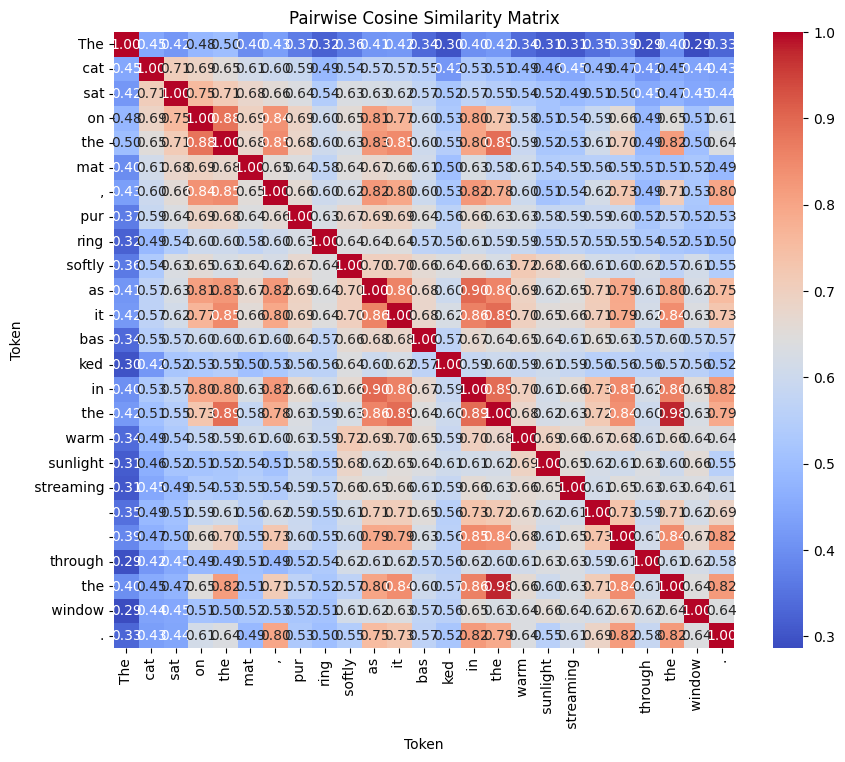

Mean Euclidean Distance: 4.582704544067383


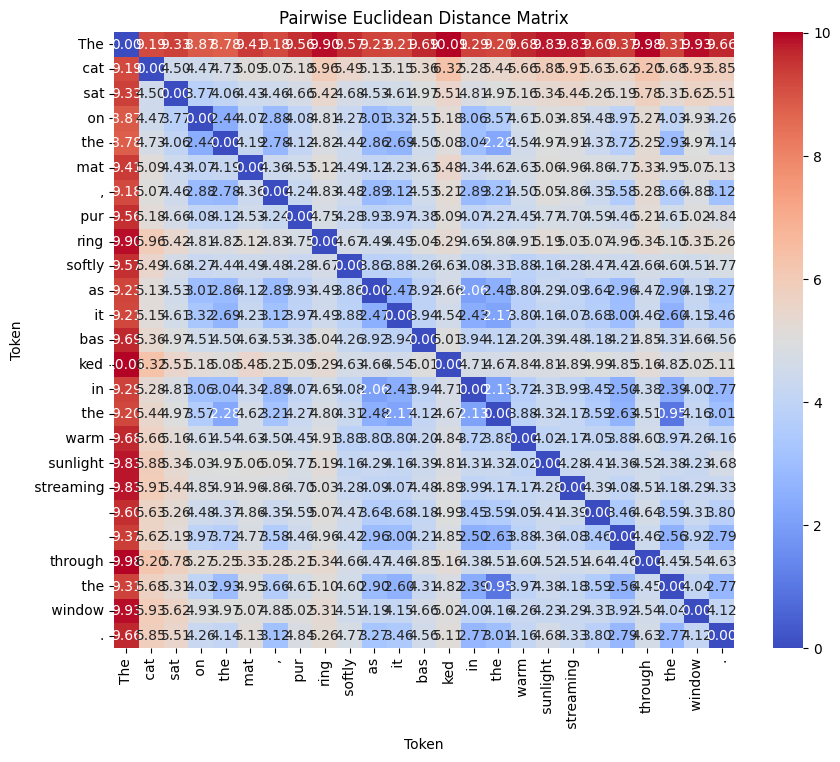

In [26]:
analysis_low = EmbeddingAnalysis(llm, low_variance_text)
analysis_low.analyze()

In [27]:
labels = ['low_text', 'text', 'high_text']

Model not supported
Model not supported
Model not supported
Model not supported
Model not supported
Model not supported
[0.6258313059806824, 0.6848686337471008, 0.5807138085365295] [4.582704544067383, 4.586528301239014, 4.793766975402832]


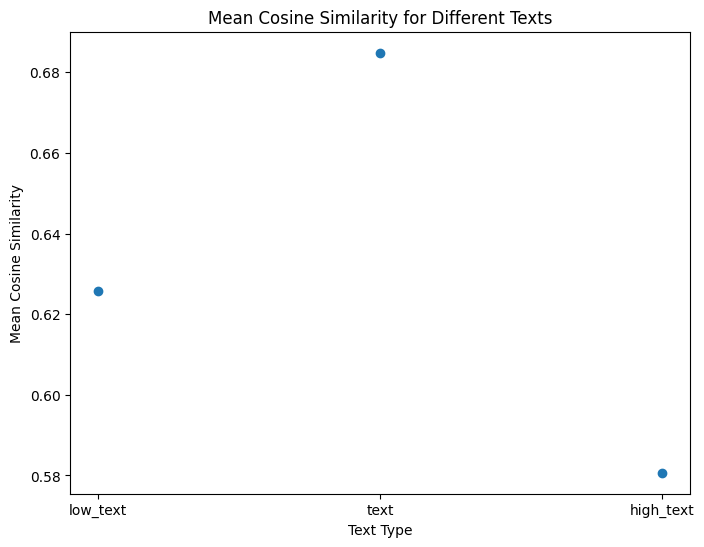

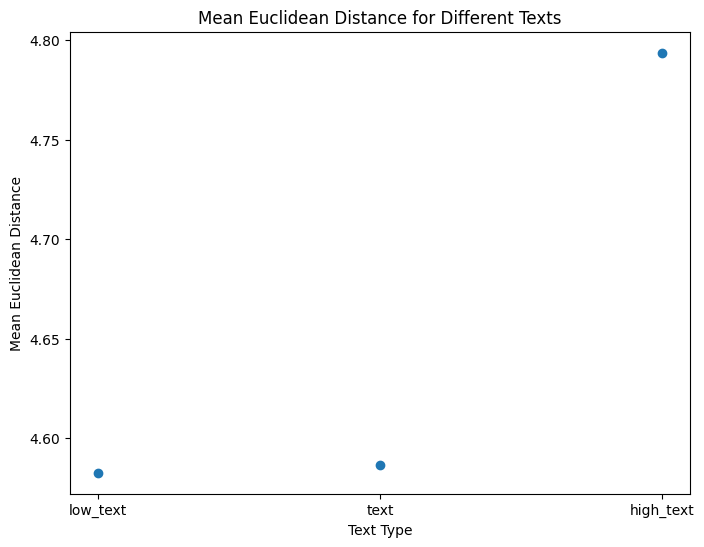

In [28]:
#analysis_low, analysis, analysis_high 
lst_mean_cosine_similarity = [analysis_low.get_mean_cosine_similarity(), analysis.get_mean_cosine_similarity(), analysis_high.get_mean_cosine_similarity()]
lst_mean_euclidean_distance = [analysis_low.get_mean_euclidean_distance(), analysis.get_mean_euclidean_distance(), analysis_high.get_mean_euclidean_distance()]
print(lst_mean_cosine_similarity, lst_mean_euclidean_distance)

def plot_similarity_distance(labels, values, ylabel, title):
    plt.figure(figsize=(8, 6))
    plt.plot(labels, values, marker='o', linestyle='None')
    plt.xlabel('Text Type')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

labels = ['low_text', 'text', 'high_text']
plot_similarity_distance(labels, lst_mean_cosine_similarity, 'Mean Cosine Similarity', 'Mean Cosine Similarity for Different Texts')
plot_similarity_distance(labels, lst_mean_euclidean_distance, 'Mean Euclidean Distance', 'Mean Euclidean Distance for Different Texts')


# Class BlocksEmbeddingAnalysis

Model not supported
Model not supported


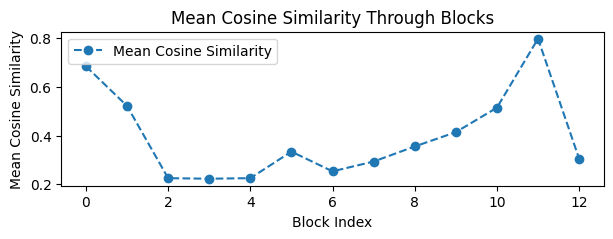

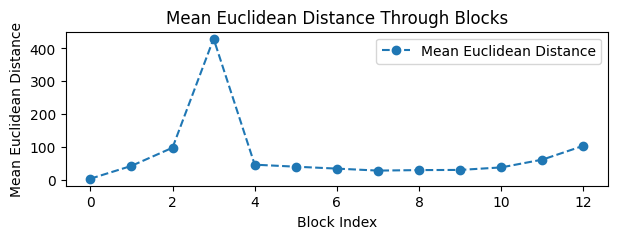

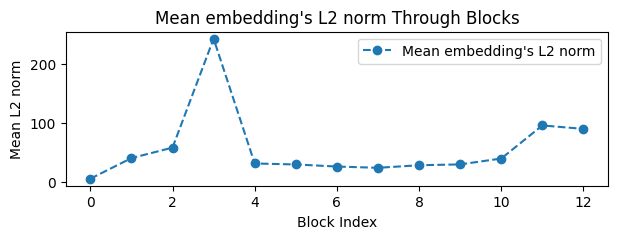

In [32]:
EmbeddingAnalysis(llm, text).analyze_through_blocks()

Model not supported
Model not supported


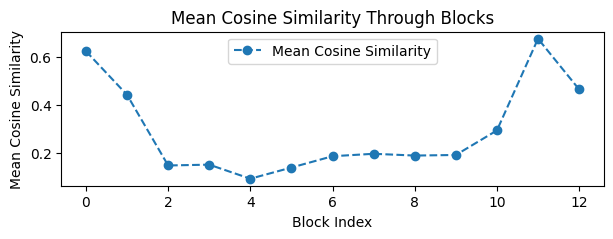

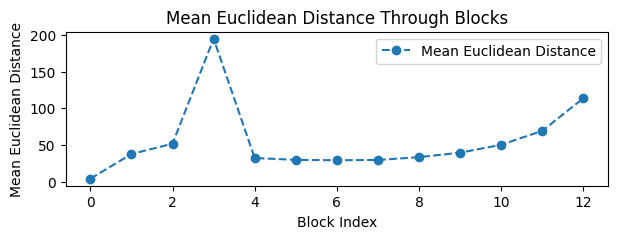

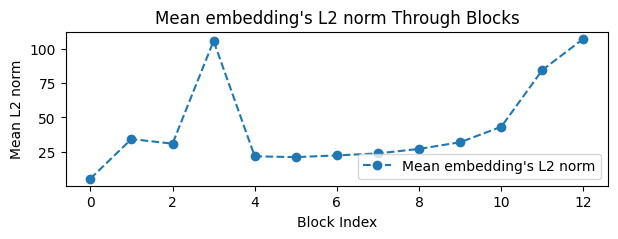

Model not supported
Model not supported


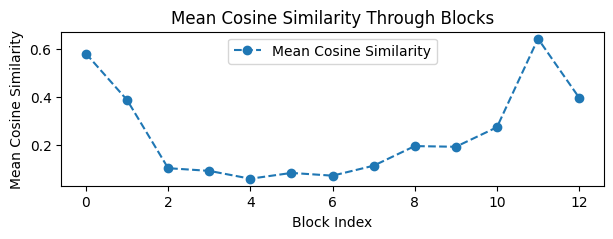

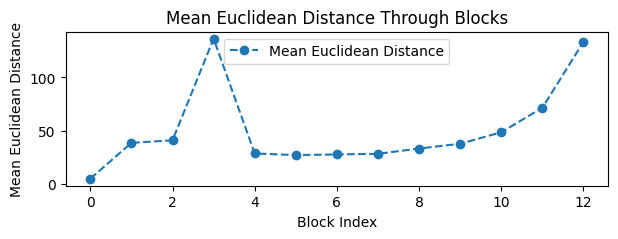

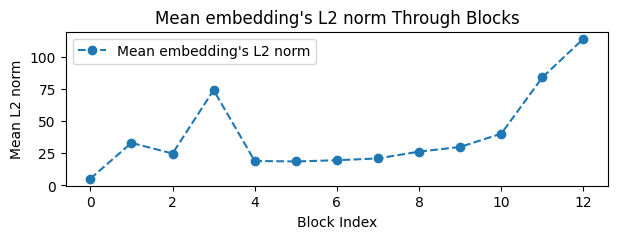

In [30]:
EmbeddingAnalysis(llm, low_variance_text).analyze_through_blocks()
EmbeddingAnalysis(llm, high_variance_text).analyze_through_blocks()

# OLD STUFF 

In [31]:
with llm.trace(text):
    input_embed = llm.transformer.drop.input.save()

embedding_variance = torch.var(input_embed[0], dim=1, unbiased=False)

# Calculate the mean variance across all dimensions
mean_variance = torch.mean(embedding_variance)

print(f"Embedding variance: {embedding_variance}")
print(f"Embedding variance shape: {embedding_variance.shape}")
print(f"Mean variance: {mean_variance}")

Embedding variance: tensor([0.1336, 0.0435, 0.0490, 0.0412, 0.0415, 0.0306, 0.0292, 0.0301, 0.0327,
        0.0286], device='cuda:0', grad_fn=<VarBackward0>)
Embedding variance shape: torch.Size([10])
Mean variance: 0.046016234904527664
